In [1]:
# Import Libs
import time
init_time = time.time()

import os
import pickle
import numpy as np
import ROOT

from functions import HistogramFunctions,AuxiliarFunctions,FigureFunctions,FitFunctions,rootnotes

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 20

current_time = time.time()
print 'Time to import libraries: %1.3f seconds'%(current_time-init_time)


Time to import libraries: 7.647 seconds


In [7]:
# Read Data

from keras.utils import np_utils

init_time = time.time()

from sklearn import datasets

output = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/DataFiles"

# import some data to play with

signal = np.load(output+"/"+"lvbb125Matrix.npy")[0:5000,[11,23,7,19,0,12]]
trgt_signal = np.ones(signal.shape[0])

all_signal = np.load(output+"/"+"lvbb125Matrix.npy")


ZZ = np.load(output+"/"+"ZZMatrix.npy")[0:5000,[11,23,7,19,0,12]]
trgt_ZZ = 0.0*np.ones(ZZ.shape[0])

all_ZZ = np.load(output+"/"+"ZZMatrix.npy")

TTbar = np.load(output+"/"+"TTbarMatrix.npy")
trgt_TTbar = -1.0*np.ones(TTbar.shape[0])

background=ZZ
trgt_bkg=trgt_ZZ

all_background = all_ZZ 

data_colors = ['b','r']
data_labels = ['signal','background']

data=np.append(signal,background,axis=0)
trgt=np.append(trgt_signal,trgt_bkg,axis=0)

all_data=np.append(all_signal,all_background,axis=0)

sparse_trgt = np_utils.to_categorical(trgt)

# for classification -> target max sparse
#trgt_sparse = np_utils.to_categorical(trgt_sinal)

current_time = time.time()
#print 'Time to import data: %1.3f seconds'%(current_time-init_time)
print "Sinal", signal.shape
print "ZZ", ZZ.shape
print data.shape
print trgt.shape
print sparse_trgt.shape
print len(data[0])
print range(len(data[0]))


Sinal (5000, 6)
ZZ (5000, 6)
(10000, 6)
(10000,)
(10000, 2)
6
[0, 1, 2, 3, 4, 5]


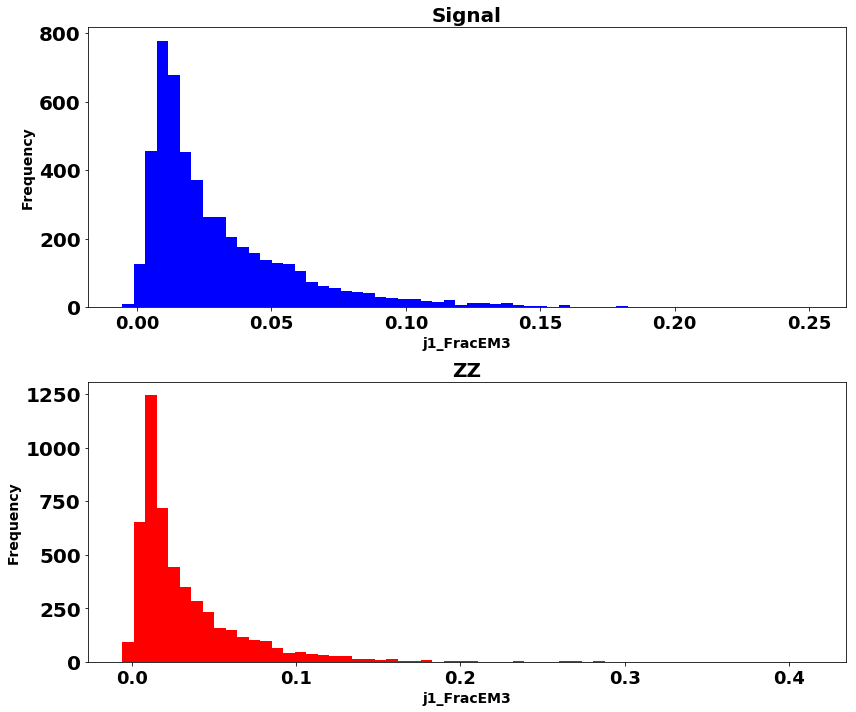

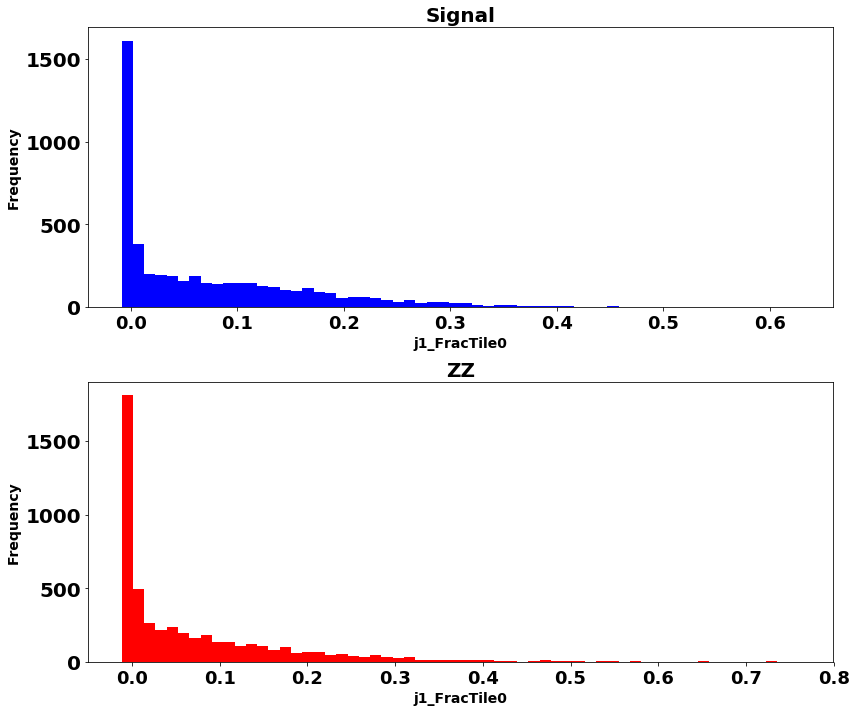

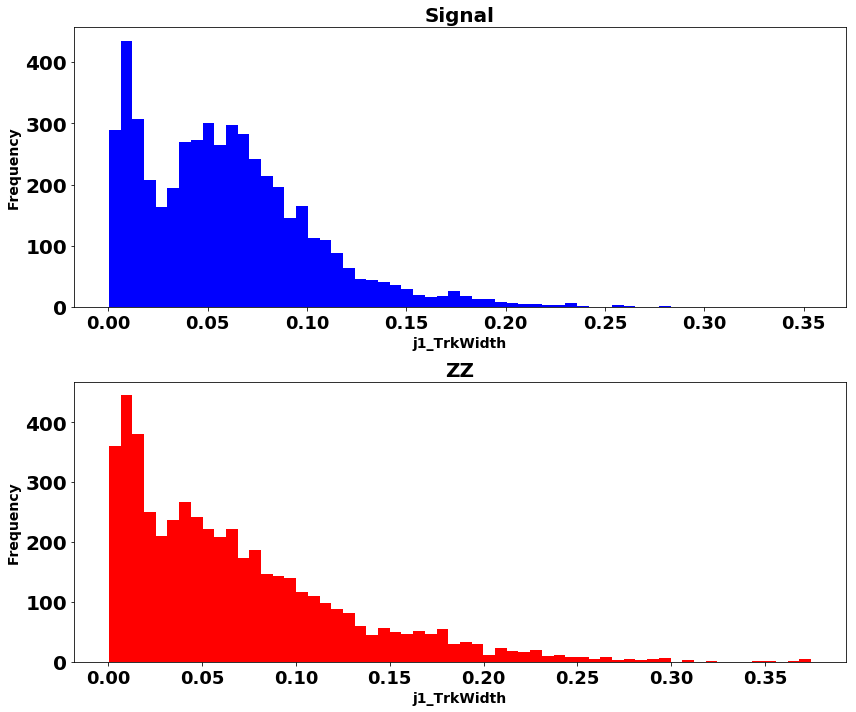

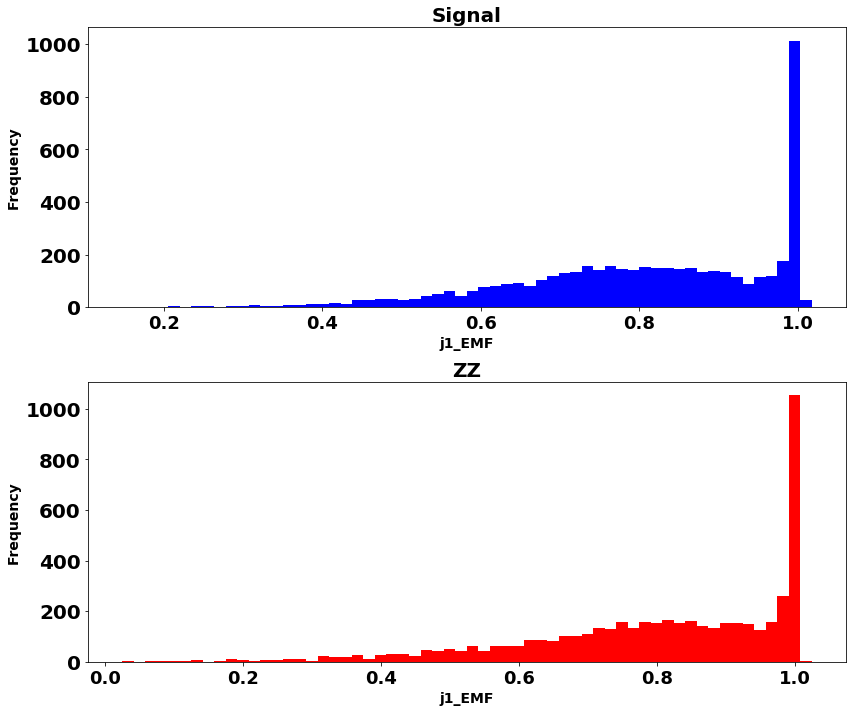

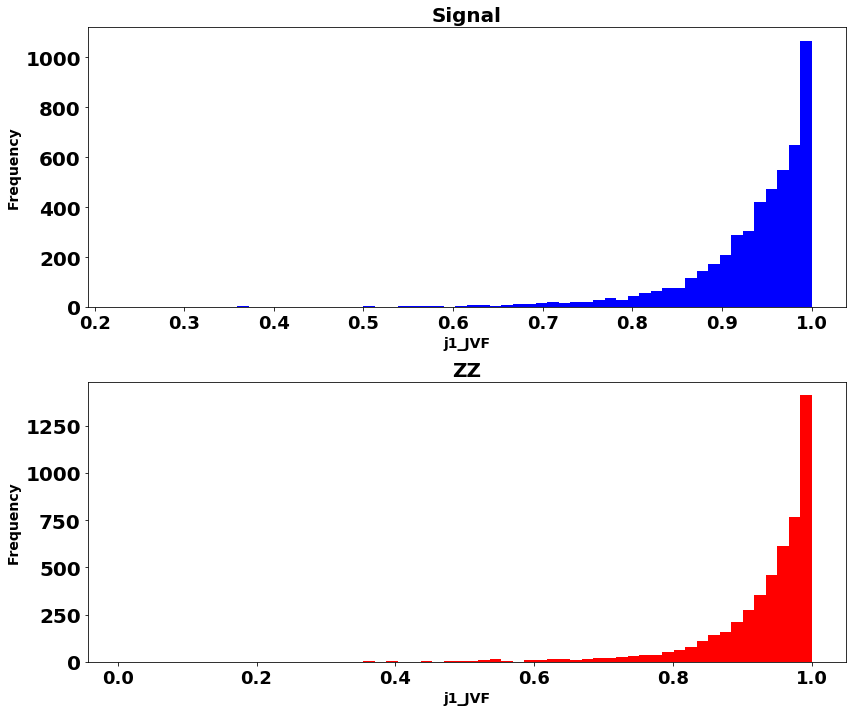

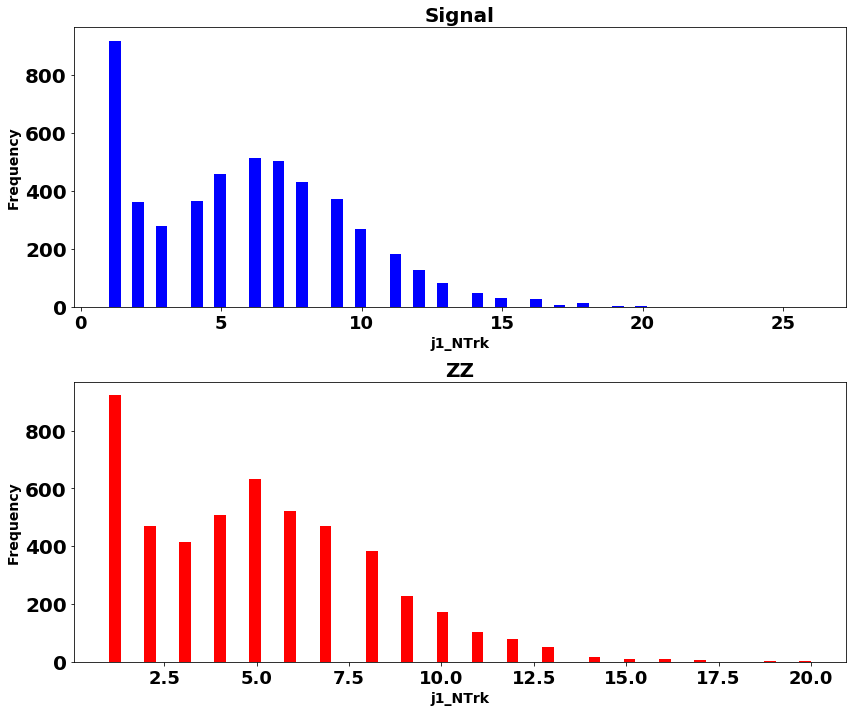

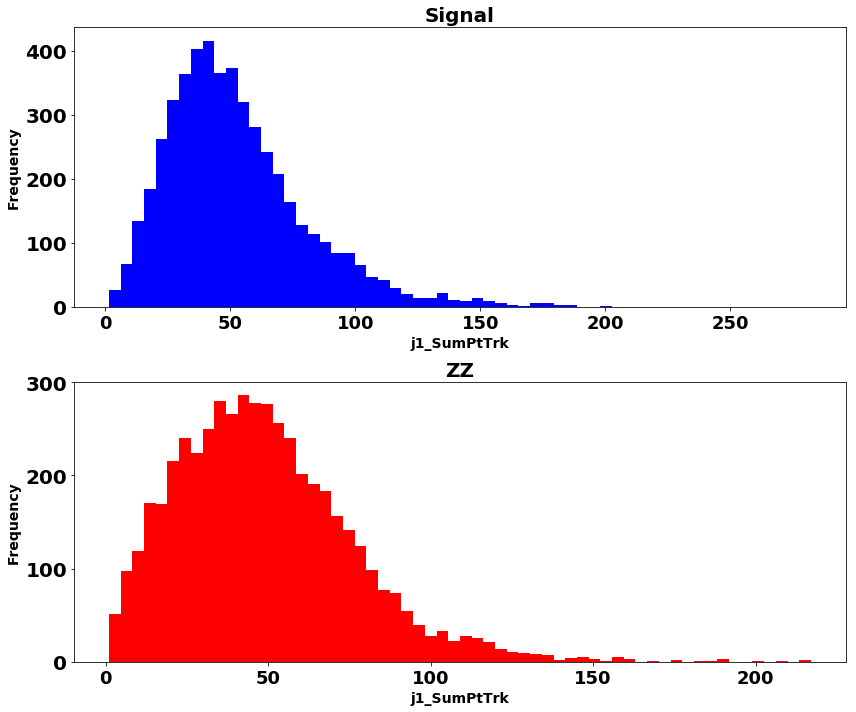

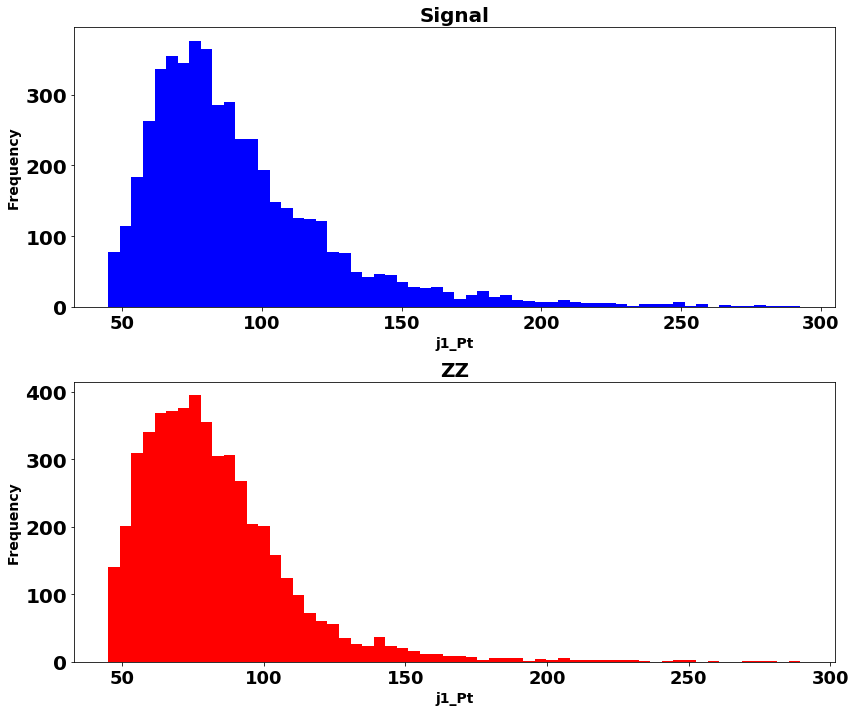

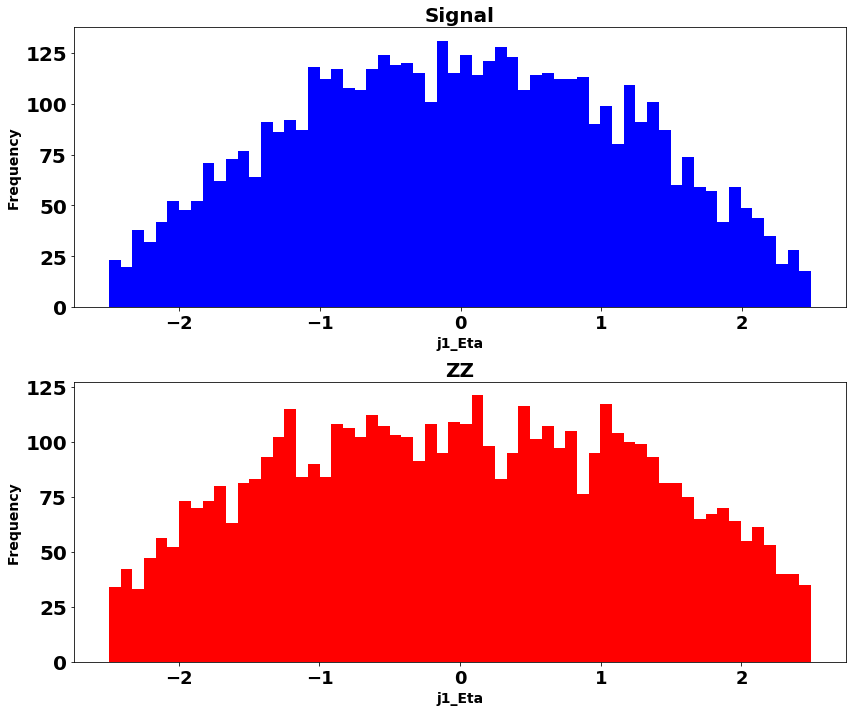

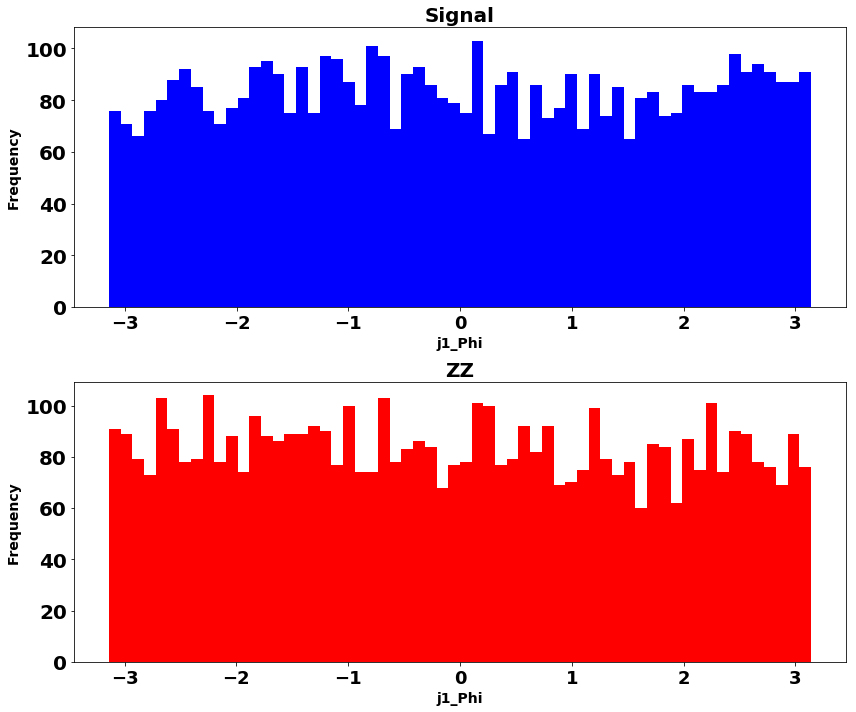

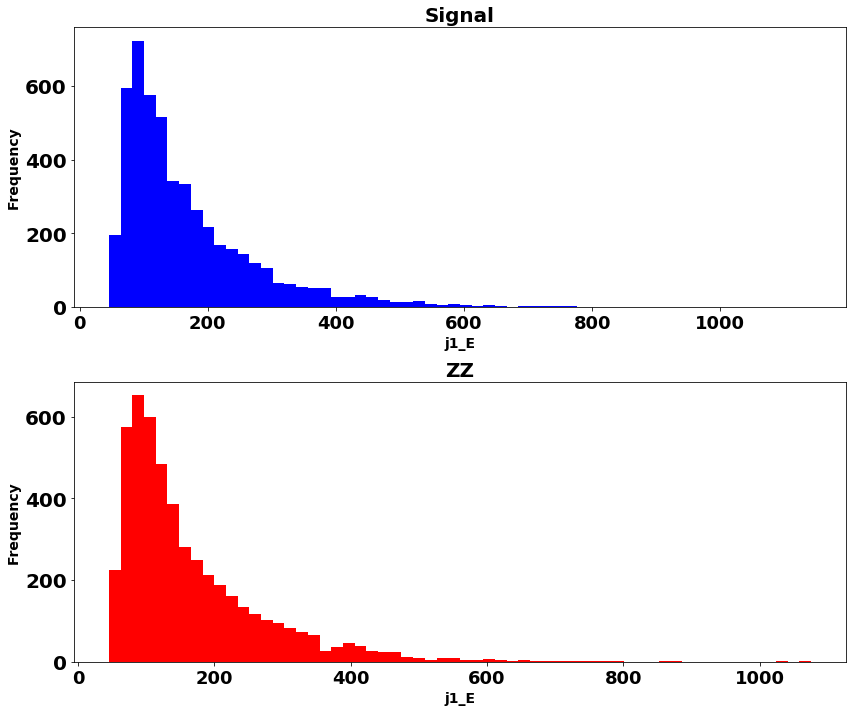

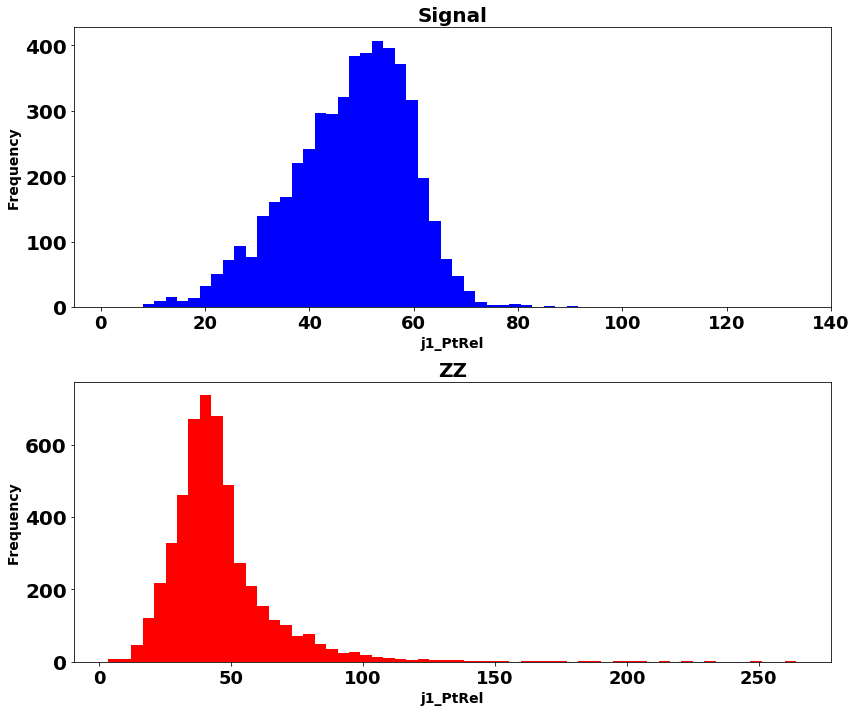

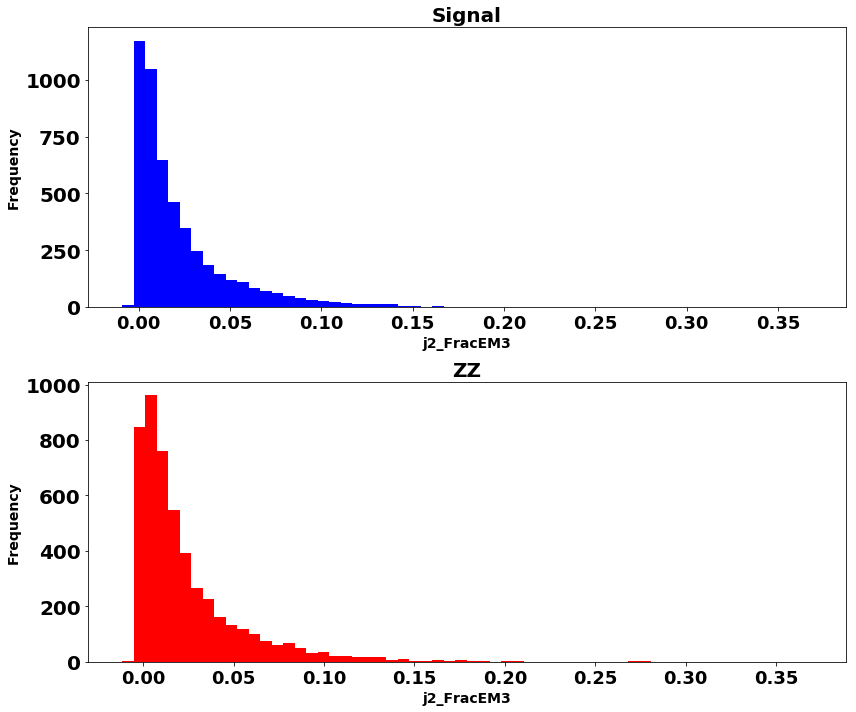

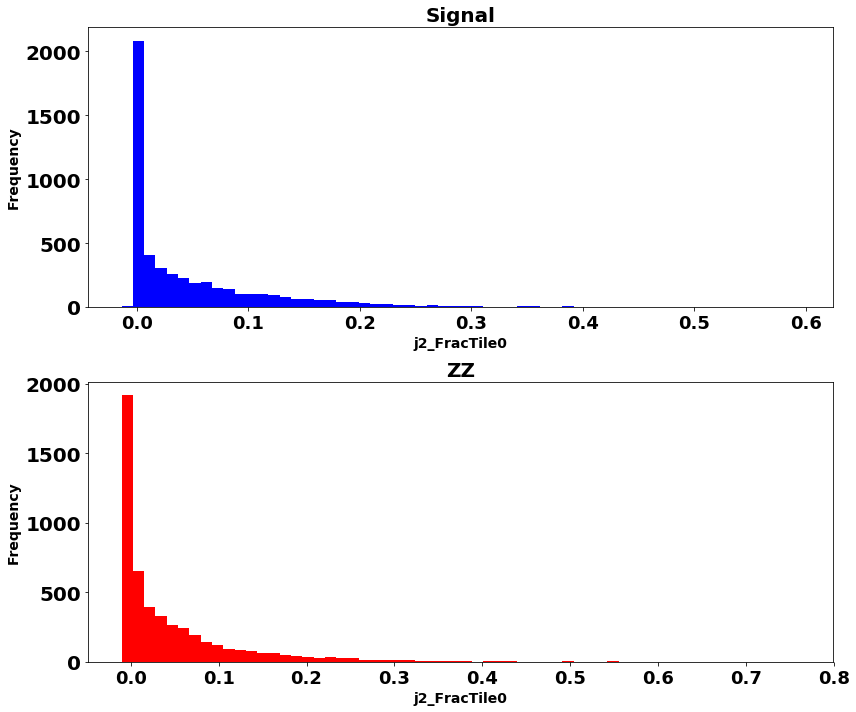

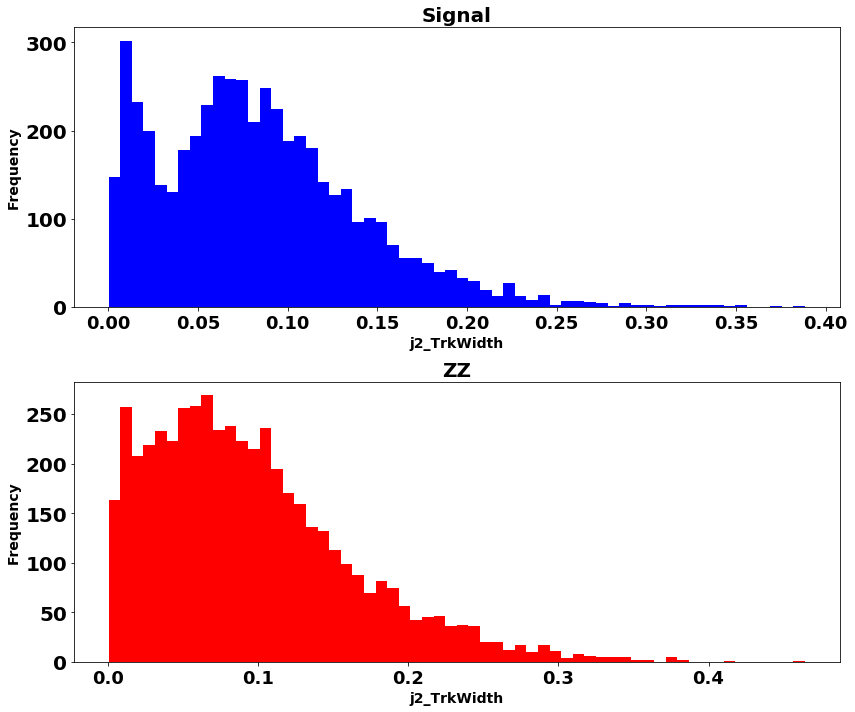

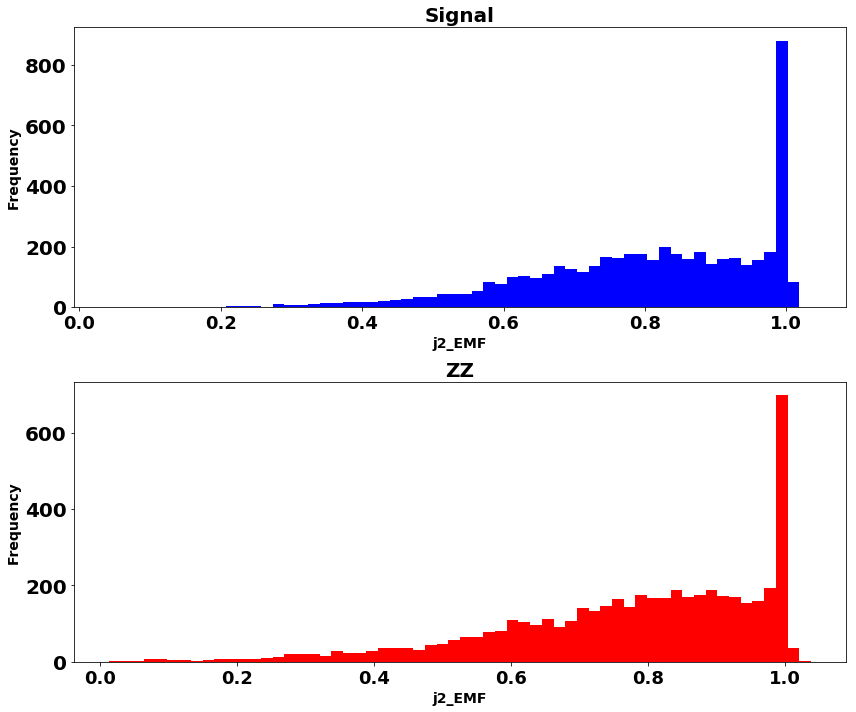

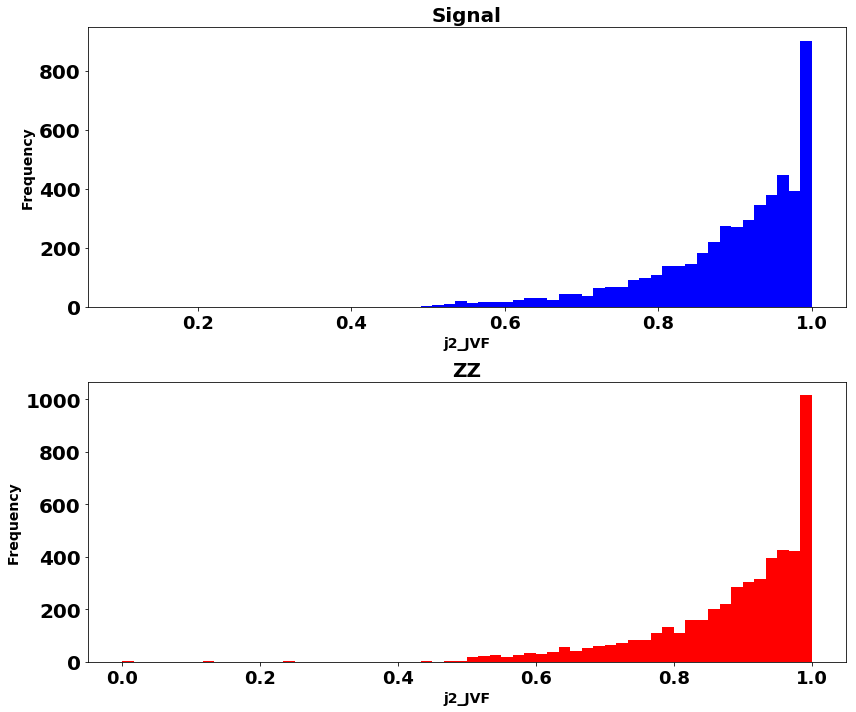

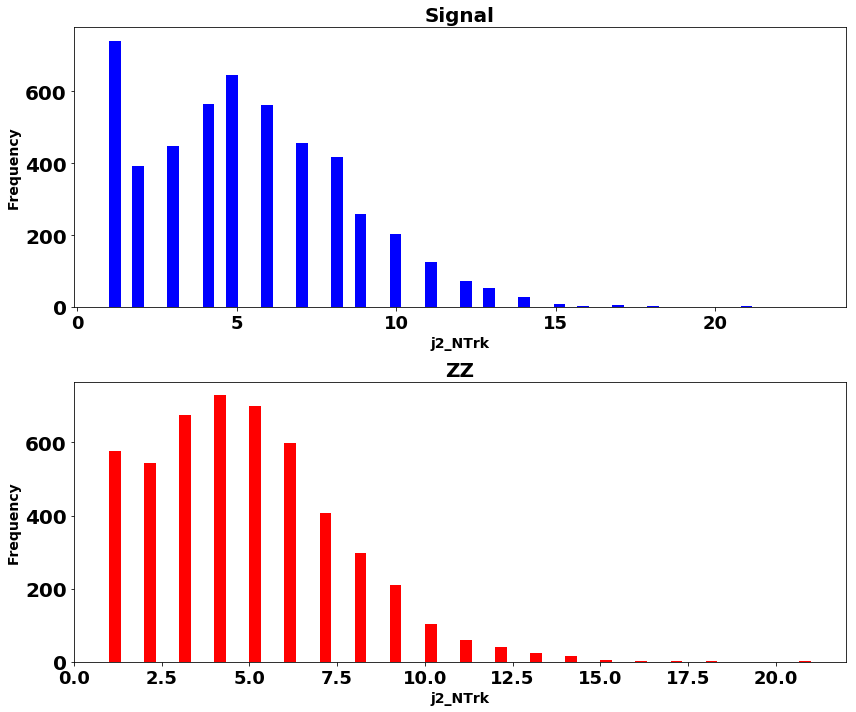

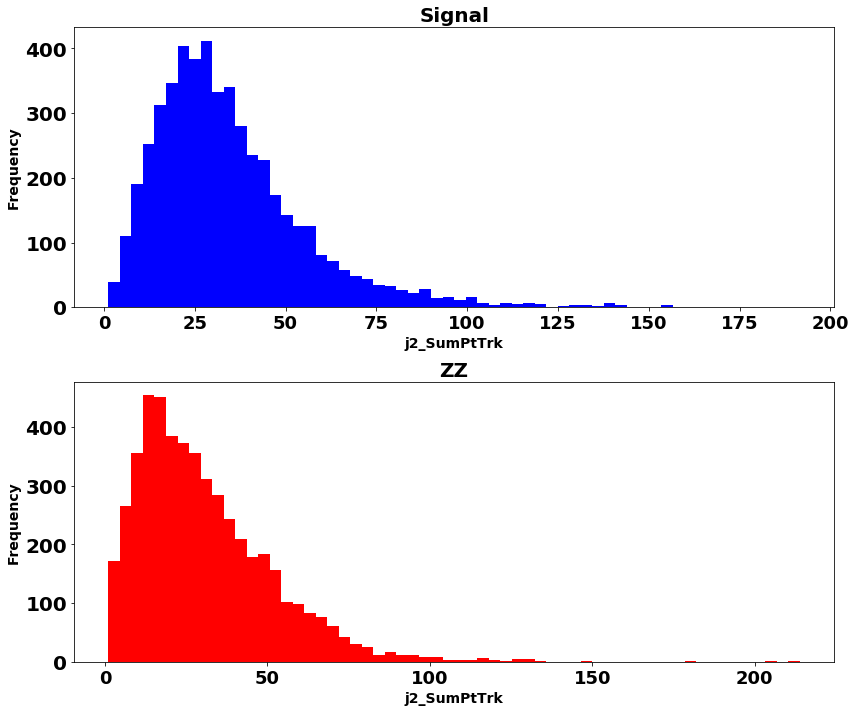

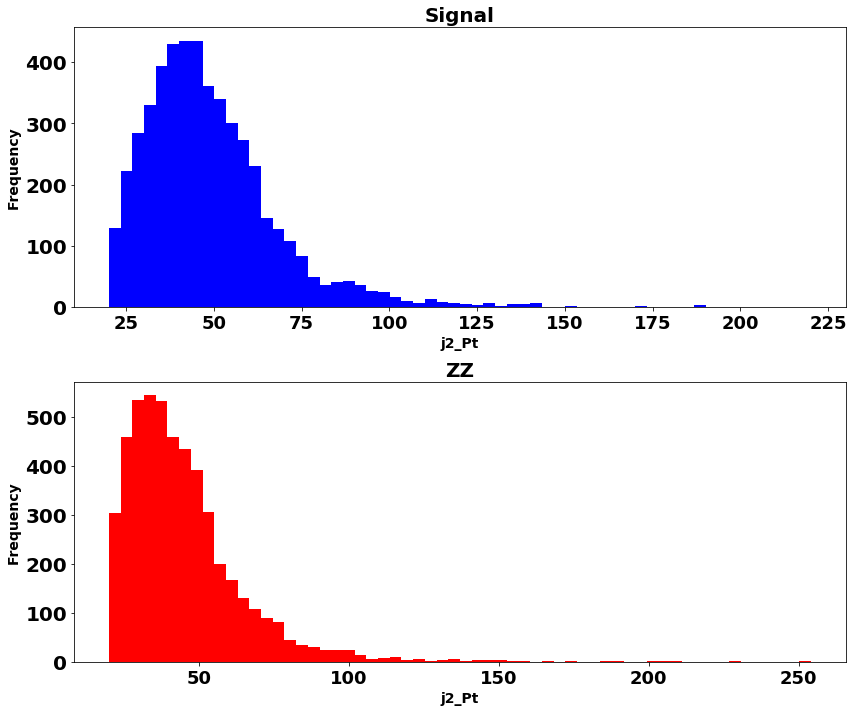

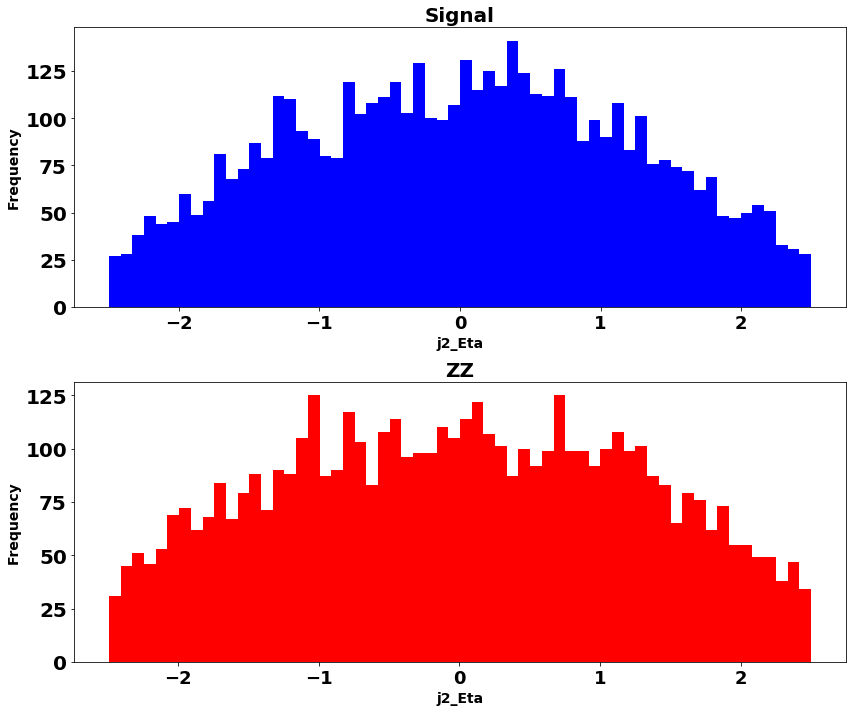

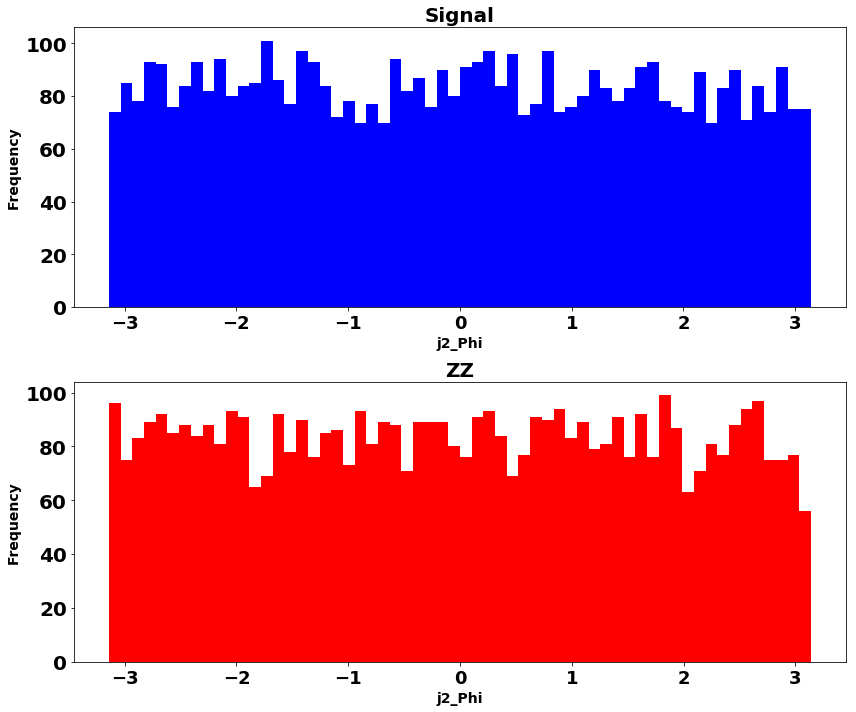

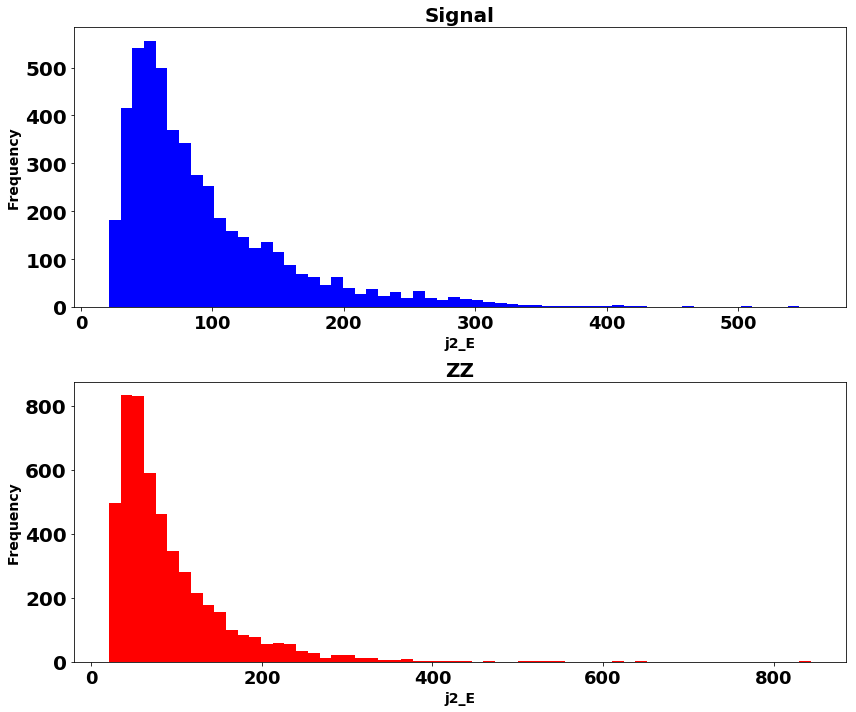

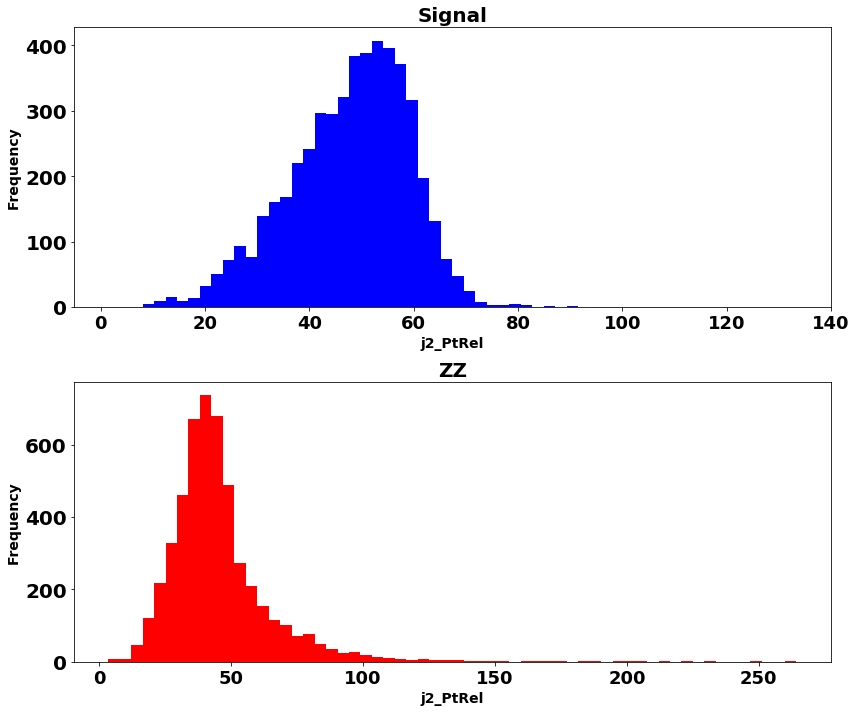

In [12]:
import matplotlib.pyplot as plt

save_point = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/"

#variables = "j1_FracEM3,j1_FracTile0,j1_TrkWidth,j1_EMF,j1_JVF,j1_NTrk,j1_SumPtTrk,j1_Pt,j1_Eta,j1_Phi,j1_E,j1_PtRel,j2_FracEM3,j2_FracTile0,j2_TrkWidth,j2_EMF,j2_JVF,j2_NTrk,j2_SumPtTrk,j2_Pt,j2_Eta,j2_Phi,j2_E,j2_PtRel"
variables = "j1_Ptrel,j2_Ptrel,j1_Pt,j2_Pt,j1_FracEM3,j2_FracEM3"

for variable,i in zip(variables.split(","),range(len(data[0]))):
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    ax1.hist(signal[:,i],60,color='b')
    ax2.hist(ZZ[:,i],60,color='r')
    
    ax1.set_title('Signal', size=20, weight='bold')
    ax1.set_xlabel(variable, size=14, weight='bold')
    ax1.set_ylabel("Frequency", size=14, weight='bold')
    #ax1.savefig(save_point+'/'+'Output_TTbar_'+str(lr)+'_'+str(decay)+'_'+str(momentum)+'.pdf')
    
    ax2.set_title('ZZ', size=20, weight='bold')
    ax2.set_xlabel(variable,size=14, weight='bold')
    ax2.set_ylabel("Frequency",size=14, weight='bold')
    
    fig.tight_layout()
    fig.savefig(save_point+'/'+variable)

In [8]:
#Train a Classifier                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils

from sklearn import cross_validation
from sklearn import preprocessing

n_folds = 2
n_inits = 2
norm = 'mapstd'

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

classifiers = {}

#SGD parameters

lr=0.001 
#decay=1e-5
decay=lr/100
momentum=0.9


for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if norm == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data[train_id,:])
    elif norm == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data[train_id,:])
    elif norm == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
    norm_data = scaler.transform(data)
    
    best_init = 0
    best_loss = 999
    
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))
        model = Sequential()
        model.add(Dense(data.shape[1],
                        input_dim=data.shape[1],
                        init='identity',
                        trainable=False))
        model.add(Activation('linear'))
        model.add(Dense(50, input_dim=data.shape[1], 
                        init='uniform'))
        model.add(Activation('tanh'))
        model.add(Dense(2,
                        init='uniform')) 
        model.add(Activation('tanh'))
        
        sgd = SGD(lr, decay, momentum)
        model.compile(loss='mean_squared_error',
                      optimizer=sgd,
                      metrics=['accuracy'])
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=25, 
                                                verbose=0, 
                                                mode='auto')
        # Train model
        init_trn_desc = model.fit(norm_data[train_id], 
                                  sparse_trgt[train_id], 
                                  nb_epoch=200, 
                                  batch_size=50, 
                                  callbacks=[earlyStopping], 
                                  verbose=True, 
                                  validation_data=(norm_data[test_id],
                                                   sparse_trgt[test_id]), 
                                  shuffle=True)
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifiers[ifold] = model

/home/isabella/.virtualenvs/pt_rel_analysis/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Processing: Fold 1 of 2 Init 1 of 2
Train on 5000 samples, validate on 5000 samples
Epoch 1/200
5000/5000 [==============================] - 0s - loss: 0.4976 - acc: 0.4870 - val_loss: 0.4972 - val_acc: 0.4770
Epoch 2/200
5000/5000 [==============================] - 0s - loss: 0.4968 - acc: 0.4872 - val_loss: 0.4968 - val_acc: 0.4774
Epoch 3/200
5000/5000 [==============================] - 0s - loss: 0.4965 - acc: 0.4872 - val_loss: 0.4966 - val_acc: 0.4774
Epoch 4/200
5000/5000 [==============================] - 0s - loss: 0.4964 - acc: 0.4876 - val_loss: 0.4964 - val_acc: 0.4774

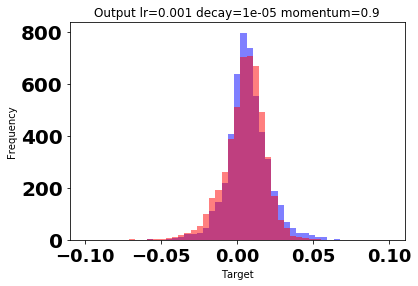

In [9]:
# analyse train process - output distribution
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

save_point = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/"

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
output_class = np.argmax(output,axis=1)

my_bins = np.linspace(-0.1, 0.1, 50)

plt.hist(output[trgt==1,1],bins=my_bins,color='b',alpha=0.5)
plt.hist(output[trgt==0,1],bins=my_bins,color='r',alpha=0.5)
plt.title('Output lr='+str(lr)+' decay='+str(decay)+' momentum='+str(momentum))
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.savefig(save_point+'/'+'Output_TTbar_'+str(lr)+'_'+str(decay)+'_'+str(momentum)+'.pdf')
plt.show()


#n_rows = trgt.shape[1]
#n_columns = output.shape[1]

#fig, ax = plt.subplots(figsize=(20,20),nrows=n_rows, ncols=n_columns)
#m_bins = np.linspace(-1., 1., 50)


#irow = 0
#icolumn = 0
#for itarget in range(trgt_sparse.shape[1]):
#    for ioutput in range(output.shape[1]):
#        m_pts = output[trgt==itarget,ioutput]
#        n, bins, patches = (ax[irow,icolumn].hist(m_pts,bins=m_bins,
                                                      #fc=iris_colors[itarget],
                                                      #alpha=0.8, normed=1))
#        for tick in ax[irow,icolumn].get_xticklabels():
#            tick.set_rotation(45)
#        ax[irow,icolumn].grid()
    
#        if irow == 0:
#            ax[irow,icolumn].set_title('Output for Neuron %i'%(ioutput+1),
#                                       fontweight='bold',fontsize=15)
#        if icolumn == 0:
#            ax[irow,icolumn].set_ylabel('Class %s'%(iris_labels[itarget]),
#                                        fontweight='bold',fontsize=15)
#        if irow == n_rows-1:
#            ax[irow,icolumn].set_xlabel('Possible Values',
#                                        fontweight='bold',fontsize=15)
    
        
#        if icolumn+1 == n_columns:
#            icolumn = 0
#            irow = irow+1
#        else:
#            icolumn = icolumn+1

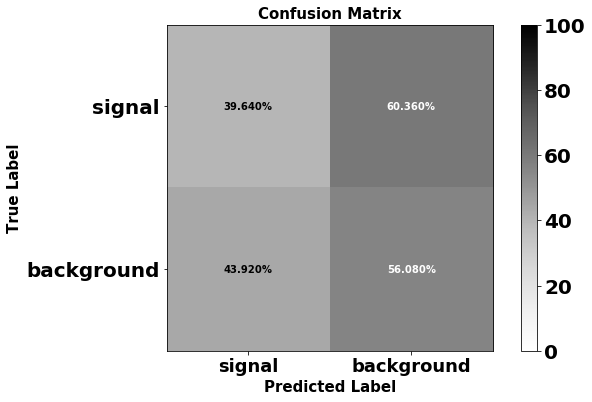

In [10]:
# analyse train process - confusion matrix
from sklearn.metrics import confusion_matrix

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
#output_class = np.argmax(output,axis=1)


cm = confusion_matrix(trgt[test_id], output_class[test_id], labels=[0,1])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)


In [81]:
print sparse_trgt[trgt==0]

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
